In [1]:
! pip install pykan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 2.3 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from kan import KAN, create_dataset

# Use double precision
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
# f(x,y) = exp(sin(πx) + y²)
f = lambda x: torch.exp(torch.sin(torch.pi * x[:, [0]]) + x[:, [1]] ** 2)

# 1000 train + 250 test, points drawn from [-1,1]²
dataset = create_dataset(
    f,
    n_var=2,
    train_num=1000,
    test_num=250,
    device=device,
)
train_x, train_y = dataset["train_input"], dataset["train_label"]
test_x,  test_y  = dataset["test_input"],  dataset["test_label"]

In [4]:
grid_sizes        = [3, 5, 10, 20, 50, 100, 200, 500, 1000]
steps_per_grid    = 200     # LBFGS steps before each refinement
k                 = 3       # cubic B-splines

# two architectures to match Figure 2.3
ARCHES = {
    "[2,5,1]":  [2, 5, 1],
    "[2,1,1]":  [2, 1, 1],
}

results = {
    name: {
        "train_curve": [],          # per-step RMSE
        "test_curve":  [],
        "train_last":  [],          # final RMSE at the end of each grid
        "test_last":   [],
        "time_step":   [],          # seconds / step for each grid
    }
    for name in ARCHES
}

In [7]:
for name, width in ARCHES.items():
    print(f"\n===== {name} =====")
    model = None

    for gi, G in enumerate(grid_sizes):
        print(f"  • grid = {G}")
        if gi == 0:
            model = KAN(width=width, grid=G, k=k, seed=42, device=device)
        else:
            model = model.refine(G)

        t0 = time.perf_counter()
        # NOTE: use keywords so nothing slides into the wrong slot
        hist = model.fit(
          dataset,
          opt="LBFGS",
          steps=steps_per_grid,
          lr=0.2,                  # <- smaller step
          lamb=0.01,
          lamb_entropy=1.0,        # <- milder entropy
          singularity_avoiding=True
        )
        t1 = time.perf_counter()

        # store per-step curves
        results[name]["train_curve"].extend(hist["train_loss"])
        results[name]["test_curve"].extend(hist["test_loss"])

        # store last value for scaling-law plot
        results[name]["train_last"].append(hist["train_loss"][-1])
        results[name]["test_last"].append(hist["test_loss"][-1])

        # timing
        results[name]["time_step"].append((t1 - t0) / steps_per_grid)


===== [2,5,1] =====
  • grid = 3
checkpoint directory created: ./model
saving model version 0.0



description:   0%|                                                          | 0/200 [00:00<?, ?it/s]
| train_loss: 3.21e-01 | test_loss: 2.51e-01 | reg: 1.16e+01 | :   0%|      | 0/200 [00:01<?, ?it/s]
| train_loss: 3.21e-01 | test_loss: 2.51e-01 | reg: 1.16e+01 | :   0%| | 1/200 [00:01<04:01,  1.21s/
| train_loss: 1.11e-01 | test_loss: 9.76e-02 | reg: 1.09e+01 | :   0%| | 1/200 [00:02<04:01,  1.21s/
| train_loss: 1.11e-01 | test_loss: 9.76e-02 | reg: 1.09e+01 | :   1%| | 2/200 [00:02<04:03,  1.23s/
| train_loss: 8.41e-02 | test_loss: 7.87e-02 | reg: 9.11e+00 | :   1%| | 2/200 [00:03<04:03,  1.23s/
| train_loss: 8.41e-02 | test_loss: 7.87e-02 | reg: 9.11e+00 | :   2%| | 3/200 [00:03<03:34,  1.09s/
| train_loss: 6.95e-02 | test_loss: 5.82e-02 | reg: 8.13e+00 | :   2%| | 3/200 [00:04<03:34,  1.09s/
| train_loss: 6.95e-02 | test_loss: 5.82e-02 | reg: 8.13e+00 | :   2%| | 4/200 [00:04<03:34,  1.10s/
| train_loss: 6.80e-02 | test_loss: 6.34e-02 | reg: 7.17e+00 | :   2%| | 4/200 [00:05<03:3

saving model version 0.1
  • grid = 5
saving model version 0.2



description:   0%|                                                          | 0/200 [00:00<?, ?it/s]
| train_loss: 6.89e-02 | test_loss: 6.88e-02 | reg: 4.56e+00 | :   0%|      | 0/200 [00:00<?, ?it/s]
| train_loss: 6.89e-02 | test_loss: 6.88e-02 | reg: 4.56e+00 | :   0%| | 1/200 [00:00<01:45,  1.88it
| train_loss: 4.25e-02 | test_loss: 4.34e-02 | reg: 4.47e+00 | :   0%| | 1/200 [00:00<01:45,  1.88it
| train_loss: 4.25e-02 | test_loss: 4.34e-02 | reg: 4.47e+00 | :   1%| | 2/200 [00:00<01:36,  2.05it
| train_loss: 4.15e-02 | test_loss: 4.24e-02 | reg: 4.44e+00 | :   1%| | 2/200 [00:01<01:36,  2.05it
| train_loss: 4.15e-02 | test_loss: 4.24e-02 | reg: 4.44e+00 | :   2%| | 3/200 [00:01<01:36,  2.04it
| train_loss: 4.00e-02 | test_loss: 4.05e-02 | reg: 4.43e+00 | :   2%| | 3/200 [00:01<01:36,  2.04it
| train_loss: 4.00e-02 | test_loss: 4.05e-02 | reg: 4.43e+00 | :   2%| | 4/200 [00:01<01:32,  2.13it
| train_loss: 3.77e-02 | test_loss: 3.84e-02 | reg: 4.43e+00 | :   2%| | 4/200 [00:02<01:3

saving model version 0.3
  • grid = 10
saving model version 0.4



description:   0%|                                                          | 0/200 [00:00<?, ?it/s]
| train_loss: 3.15e-01 | test_loss: 2.95e-01 | reg: 4.85e+00 | :   0%|      | 0/200 [00:00<?, ?it/s]
| train_loss: 3.15e-01 | test_loss: 2.95e-01 | reg: 4.85e+00 | :   0%| | 1/200 [00:00<02:11,  1.51it
| train_loss: 4.41e-02 | test_loss: 4.09e-02 | reg: 4.78e+00 | :   0%| | 1/200 [00:01<02:11,  1.51it
| train_loss: 4.41e-02 | test_loss: 4.09e-02 | reg: 4.78e+00 | :   1%| | 2/200 [00:01<01:59,  1.65it
| train_loss: 4.00e-02 | test_loss: 3.71e-02 | reg: 4.79e+00 | :   1%| | 2/200 [00:02<01:59,  1.65it
| train_loss: 4.00e-02 | test_loss: 3.71e-02 | reg: 4.79e+00 | :   2%| | 3/200 [00:02<02:15,  1.45it
| train_loss: 3.98e-02 | test_loss: 3.71e-02 | reg: 4.79e+00 | :   2%| | 3/200 [00:02<02:15,  1.45it
| train_loss: 3.98e-02 | test_loss: 3.71e-02 | reg: 4.79e+00 | :   2%| | 4/200 [00:02<02:11,  1.49it
| train_loss: 3.97e-02 | test_loss: 3.70e-02 | reg: 4.79e+00 | :   2%| | 4/200 [00:03<02:1

saving model version 0.5
  • grid = 20
saving model version 0.6



description:   0%|                                                          | 0/200 [00:00<?, ?it/s]
| train_loss: 1.39e-02 | test_loss: 1.29e-02 | reg: 4.44e+00 | :   0%|      | 0/200 [00:01<?, ?it/s]
| train_loss: 1.39e-02 | test_loss: 1.29e-02 | reg: 4.44e+00 | :   0%| | 1/200 [00:01<04:00,  1.21s/
| train_loss: 1.38e-02 | test_loss: 1.29e-02 | reg: 4.44e+00 | :   0%| | 1/200 [00:02<04:00,  1.21s/
| train_loss: 1.38e-02 | test_loss: 1.29e-02 | reg: 4.44e+00 | :   1%| | 2/200 [00:02<03:40,  1.11s/
| train_loss: 1.38e-02 | test_loss: 1.29e-02 | reg: 4.44e+00 | :   1%| | 2/200 [00:03<03:40,  1.11s/
| train_loss: 1.38e-02 | test_loss: 1.29e-02 | reg: 4.44e+00 | :   2%| | 3/200 [00:03<03:12,  1.02it
| train_loss: 1.37e-02 | test_loss: 1.28e-02 | reg: 4.44e+00 | :   2%| | 3/200 [00:03<03:12,  1.02it
| train_loss: 1.37e-02 | test_loss: 1.28e-02 | reg: 4.44e+00 | :   2%| | 4/200 [00:03<02:52,  1.14it
| train_loss: 1.37e-02 | test_loss: 1.28e-02 | reg: 4.44e+00 | :   2%| | 4/200 [00:04<02:5

saving model version 0.7
  • grid = 50
saving model version 0.8



description:   0%|                                                          | 0/200 [00:00<?, ?it/s]
| train_loss: 1.35e-02 | test_loss: 1.26e-02 | reg: 4.44e+00 | :   0%|      | 0/200 [00:02<?, ?it/s]
| train_loss: 1.35e-02 | test_loss: 1.26e-02 | reg: 4.44e+00 | :   0%| | 1/200 [00:02<08:15,  2.49s/
| train_loss: 1.35e-02 | test_loss: 1.26e-02 | reg: 4.44e+00 | :   0%| | 1/200 [00:03<08:15,  2.49s/
| train_loss: 1.35e-02 | test_loss: 1.26e-02 | reg: 4.44e+00 | :   1%| | 2/200 [00:03<06:16,  1.90s/
| train_loss: 1.35e-02 | test_loss: 1.26e-02 | reg: 4.44e+00 | :   1%| | 2/200 [00:05<06:16,  1.90s/
| train_loss: 1.35e-02 | test_loss: 1.26e-02 | reg: 4.44e+00 | :   2%| | 3/200 [00:05<05:23,  1.64s/
| train_loss: 1.35e-02 | test_loss: 1.26e-02 | reg: 4.44e+00 | :   2%| | 3/200 [00:06<05:23,  1.64s/
| train_loss: 1.35e-02 | test_loss: 1.26e-02 | reg: 4.44e+00 | :   2%| | 4/200 [00:06<04:51,  1.48s/
| train_loss: 1.35e-02 | test_loss: 1.26e-02 | reg: 4.44e+00 | :   2%| | 4/200 [00:07<04:5

saving model version 0.9
  • grid = 100
saving model version 0.10



description:   0%|                                                          | 0/200 [00:00<?, ?it/s]
| train_loss: 4.06e-02 | test_loss: 2.43e-02 | reg: 4.46e+00 | :   0%|      | 0/200 [00:03<?, ?it/s]
| train_loss: 4.06e-02 | test_loss: 2.43e-02 | reg: 4.46e+00 | :   0%| | 1/200 [00:03<10:29,  3.16s/
| train_loss: 3.40e-02 | test_loss: 2.41e-02 | reg: 4.47e+00 | :   0%| | 1/200 [00:06<10:29,  3.16s/
| train_loss: 3.40e-02 | test_loss: 2.41e-02 | reg: 4.47e+00 | :   1%| | 2/200 [00:06<11:32,  3.50s/
| train_loss: 3.38e-02 | test_loss: 2.40e-02 | reg: 4.47e+00 | :   1%| | 2/200 [00:10<11:32,  3.50s/
| train_loss: 3.38e-02 | test_loss: 2.40e-02 | reg: 4.47e+00 | :   2%| | 3/200 [00:10<10:55,  3.33s/
| train_loss: 3.27e-02 | test_loss: 2.22e-02 | reg: 4.46e+00 | :   2%| | 3/200 [00:13<10:55,  3.33s/
| train_loss: 3.27e-02 | test_loss: 2.22e-02 | reg: 4.46e+00 | :   2%| | 4/200 [00:13<10:44,  3.29s/
| train_loss: 3.23e-02 | test_loss: 2.15e-02 | reg: 4.46e+00 | :   2%| | 4/200 [00:16<10:4

saving model version 0.11
  • grid = 200
saving model version 0.12



description:   0%|                                                          | 0/200 [00:00<?, ?it/s]
| train_loss: 1.50e+00 | test_loss: 1.30e+00 | reg: 8.37e+00 | :   0%|      | 0/200 [00:06<?, ?it/s]
| train_loss: 1.50e+00 | test_loss: 1.30e+00 | reg: 8.37e+00 | :   0%| | 1/200 [00:06<20:21,  6.14s/
| train_loss: 1.11e+00 | test_loss: 1.13e+00 | reg: 1.05e+01 | :   0%| | 1/200 [00:11<20:21,  6.14s/
| train_loss: 1.11e+00 | test_loss: 1.13e+00 | reg: 1.05e+01 | :   1%| | 2/200 [00:11<19:28,  5.90s/
| train_loss: 1.05e+00 | test_loss: 1.09e+00 | reg: 1.05e+01 | :   1%| | 2/200 [00:17<19:28,  5.90s/
| train_loss: 1.05e+00 | test_loss: 1.09e+00 | reg: 1.05e+01 | :   2%| | 3/200 [00:17<18:49,  5.73s/
| train_loss: 9.99e-01 | test_loss: 1.07e+00 | reg: 1.05e+01 | :   2%| | 3/200 [00:22<18:49,  5.73s/
| train_loss: 9.99e-01 | test_loss: 1.07e+00 | reg: 1.05e+01 | :   2%| | 4/200 [00:22<18:22,  5.63s/
| train_loss: 9.50e-01 | test_loss: 1.03e+00 | reg: 1.05e+01 | :   2%| | 4/200 [00:28<18:2

saving model version 0.13
  • grid = 500
saving model version 0.14



description:   0%|                                                          | 0/200 [00:00<?, ?it/s]
| train_loss: 1.36e+00 | test_loss: 1.24e+00 | reg: 8.06e+00 | :   0%|      | 0/200 [00:14<?, ?it/s]
| train_loss: 1.36e+00 | test_loss: 1.24e+00 | reg: 8.06e+00 | :   0%| | 1/200 [00:14<49:04, 14.80s/
| train_loss: 1.11e+00 | test_loss: 9.71e-01 | reg: 9.65e+00 | :   0%| | 1/200 [00:30<49:04, 14.80s/
| train_loss: 1.11e+00 | test_loss: 9.71e-01 | reg: 9.65e+00 | :   1%| | 2/200 [00:30<51:02, 15.47s/
| train_loss: 1.00e+00 | test_loss: 9.60e-01 | reg: 9.78e+00 | :   1%| | 2/200 [00:43<51:02, 15.47s/
| train_loss: 1.00e+00 | test_loss: 9.60e-01 | reg: 9.78e+00 | :   2%| | 3/200 [00:43<46:15, 14.09s/
| train_loss: 9.34e-01 | test_loss: 9.65e-01 | reg: 9.92e+00 | :   2%| | 3/200 [00:57<46:15, 14.09s/
| train_loss: 9.34e-01 | test_loss: 9.65e-01 | reg: 9.92e+00 | :   2%| | 4/200 [00:57<45:48, 14.02s/
| train_loss: 8.80e-01 | test_loss: 9.60e-01 | reg: 1.01e+01 | :   2%| | 4/200 [01:10<45:4

saving model version 0.15
  • grid = 1000
saving model version 0.16



description:   0%|                                                          | 0/200 [00:00<?, ?it/s]
| train_loss: 1.51e+00 | test_loss: 1.36e+00 | reg: 1.02e+01 | :   0%|      | 0/200 [00:50<?, ?it/s]
| train_loss: 1.51e+00 | test_loss: 1.36e+00 | reg: 1.02e+01 | :   0%| | 1/200 [00:50<2:47:09, 50.40
| train_loss: 1.28e+00 | test_loss: 1.14e+00 | reg: 1.06e+01 | :   0%| | 1/200 [01:36<2:47:09, 50.40
| train_loss: 1.28e+00 | test_loss: 1.14e+00 | reg: 1.06e+01 | :   1%| | 2/200 [01:36<2:37:49, 47.82
| train_loss: 1.23e+00 | test_loss: 1.13e+00 | reg: 1.06e+01 | :   1%| | 2/200 [02:35<2:37:49, 47.82
| train_loss: 1.23e+00 | test_loss: 1.13e+00 | reg: 1.06e+01 | :   2%| | 3/200 [02:35<2:54:14, 53.07
| train_loss: 1.19e+00 | test_loss: 1.11e+00 | reg: 1.06e+01 | :   2%| | 3/200 [03:32<2:54:14, 53.07
| train_loss: 1.19e+00 | test_loss: 1.11e+00 | reg: 1.06e+01 | :   2%| | 4/200 [03:32<2:57:31, 54.34
| train_loss: 1.17e+00 | test_loss: 1.11e+00 | reg: 1.06e+01 | :   2%| | 4/200 [04:21<2:57

saving model version 0.17

===== [2,1,1] =====
  • grid = 3
checkpoint directory created: ./model
saving model version 0.0



description:   0%|                                                          | 0/200 [00:00<?, ?it/s]
| train_loss: 6.83e-01 | test_loss: 5.77e-01 | reg: 5.18e+00 | :   0%|      | 0/200 [00:00<?, ?it/s]
| train_loss: 6.83e-01 | test_loss: 5.77e-01 | reg: 5.18e+00 | :   0%| | 1/200 [00:00<01:10,  2.82it
| train_loss: 6.67e-01 | test_loss: 5.68e-01 | reg: 5.15e+00 | :   0%| | 1/200 [00:00<01:10,  2.82it
| train_loss: 6.67e-01 | test_loss: 5.68e-01 | reg: 5.15e+00 | :   1%| | 2/200 [00:00<01:01,  3.21it
| train_loss: 6.52e-01 | test_loss: 5.54e-01 | reg: 5.15e+00 | :   1%| | 2/200 [00:00<01:01,  3.21it
| train_loss: 6.52e-01 | test_loss: 5.54e-01 | reg: 5.15e+00 | :   2%| | 3/200 [00:00<00:59,  3.30it
| train_loss: 6.44e-01 | test_loss: 5.41e-01 | reg: 5.23e+00 | :   2%| | 3/200 [00:01<00:59,  3.30it
| train_loss: 6.44e-01 | test_loss: 5.41e-01 | reg: 5.23e+00 | :   2%| | 4/200 [00:01<00:57,  3.39it
| train_loss: 6.25e-01 | test_loss: 5.11e-01 | reg: 5.15e+00 | :   2%| | 4/200 [00:01<00:5

saving model version 0.1
  • grid = 5
saving model version 0.2



description:   0%|                                                          | 0/200 [00:00<?, ?it/s]
| train_loss: 6.56e-01 | test_loss: 5.75e-01 | reg: 4.84e+00 | :   0%|      | 0/200 [00:00<?, ?it/s]
| train_loss: 6.56e-01 | test_loss: 5.75e-01 | reg: 4.84e+00 | :   0%| | 1/200 [00:00<01:34,  2.10it
| train_loss: 6.41e-01 | test_loss: 5.49e-01 | reg: 4.81e+00 | :   0%| | 1/200 [00:00<01:34,  2.10it
| train_loss: 6.41e-01 | test_loss: 5.49e-01 | reg: 4.81e+00 | :   1%| | 2/200 [00:00<01:26,  2.29it
| train_loss: 6.39e-01 | test_loss: 5.46e-01 | reg: 4.84e+00 | :   1%| | 2/200 [00:01<01:26,  2.29it
| train_loss: 6.39e-01 | test_loss: 5.46e-01 | reg: 4.84e+00 | :   2%| | 3/200 [00:01<01:18,  2.52it
| train_loss: 6.38e-01 | test_loss: 5.47e-01 | reg: 4.86e+00 | :   2%| | 3/200 [00:01<01:18,  2.52it
| train_loss: 6.38e-01 | test_loss: 5.47e-01 | reg: 4.86e+00 | :   2%| | 4/200 [00:01<01:11,  2.73it
| train_loss: 6.36e-01 | test_loss: 5.45e-01 | reg: 4.86e+00 | :   2%| | 4/200 [00:01<01:1

saving model version 0.3
  • grid = 10
saving model version 0.4



description:   0%|                                                          | 0/200 [00:00<?, ?it/s]
| train_loss: 5.46e-01 | test_loss: 4.38e-01 | reg: 4.81e+00 | :   0%|      | 0/200 [00:00<?, ?it/s]
| train_loss: 5.46e-01 | test_loss: 4.38e-01 | reg: 4.81e+00 | :   0%| | 1/200 [00:00<01:40,  1.99it
| train_loss: 5.40e-01 | test_loss: 4.33e-01 | reg: 4.81e+00 | :   0%| | 1/200 [00:00<01:40,  1.99it
| train_loss: 5.40e-01 | test_loss: 4.33e-01 | reg: 4.81e+00 | :   1%| | 2/200 [00:00<01:37,  2.04it
| train_loss: 5.34e-01 | test_loss: 4.28e-01 | reg: 4.81e+00 | :   1%| | 2/200 [00:01<01:37,  2.04it
| train_loss: 5.34e-01 | test_loss: 4.28e-01 | reg: 4.81e+00 | :   2%| | 3/200 [00:01<01:29,  2.20it
| train_loss: 5.32e-01 | test_loss: 4.30e-01 | reg: 4.81e+00 | :   2%| | 3/200 [00:01<01:29,  2.20it
| train_loss: 5.32e-01 | test_loss: 4.30e-01 | reg: 4.81e+00 | :   2%| | 4/200 [00:01<01:18,  2.51it
| train_loss: 5.30e-01 | test_loss: 4.34e-01 | reg: 4.81e+00 | :   2%| | 4/200 [00:02<01:1

saving model version 0.5
  • grid = 20
saving model version 0.6



description:   0%|                                                          | 0/200 [00:00<?, ?it/s]
| train_loss: 3.81e-01 | test_loss: 3.56e-01 | reg: 6.08e+00 | :   0%|      | 0/200 [00:00<?, ?it/s]
| train_loss: 3.81e-01 | test_loss: 3.56e-01 | reg: 6.08e+00 | :   0%| | 1/200 [00:00<01:22,  2.42it
| train_loss: 3.10e-01 | test_loss: 2.73e-01 | reg: 6.00e+00 | :   0%| | 1/200 [00:00<01:22,  2.42it
| train_loss: 3.10e-01 | test_loss: 2.73e-01 | reg: 6.00e+00 | :   1%| | 2/200 [00:00<01:13,  2.70it
| train_loss: 3.03e-01 | test_loss: 2.58e-01 | reg: 5.98e+00 | :   1%| | 2/200 [00:01<01:13,  2.70it
| train_loss: 3.03e-01 | test_loss: 2.58e-01 | reg: 5.98e+00 | :   2%| | 3/200 [00:01<01:10,  2.79it
| train_loss: 2.21e-01 | test_loss: 1.87e-01 | reg: 5.78e+00 | :   2%| | 3/200 [00:01<01:10,  2.79it
| train_loss: 2.21e-01 | test_loss: 1.87e-01 | reg: 5.78e+00 | :   2%| | 4/200 [00:01<01:11,  2.75it
| train_loss: 1.83e-01 | test_loss: 1.47e-01 | reg: 5.74e+00 | :   2%| | 4/200 [00:01<01:1

saving model version 0.7
  • grid = 50
saving model version 0.8



description:   0%|                                                          | 0/200 [00:00<?, ?it/s]
| train_loss: 5.04e-02 | test_loss: 4.91e-02 | reg: 5.42e+00 | :   0%|      | 0/200 [00:00<?, ?it/s]
| train_loss: 5.04e-02 | test_loss: 4.91e-02 | reg: 5.42e+00 | :   0%| | 1/200 [00:00<02:55,  1.13it
| train_loss: 3.61e-02 | test_loss: 3.60e-02 | reg: 5.44e+00 | :   0%| | 1/200 [00:01<02:55,  1.13it
| train_loss: 3.61e-02 | test_loss: 3.60e-02 | reg: 5.44e+00 | :   1%| | 2/200 [00:01<02:46,  1.19it
| train_loss: 2.95e-02 | test_loss: 3.38e-02 | reg: 5.43e+00 | :   1%| | 2/200 [00:02<02:46,  1.19it
| train_loss: 2.95e-02 | test_loss: 3.38e-02 | reg: 5.43e+00 | :   2%| | 3/200 [00:02<02:29,  1.32it
| train_loss: 2.61e-02 | test_loss: 2.55e-02 | reg: 5.43e+00 | :   2%| | 3/200 [00:02<02:29,  1.32it
| train_loss: 2.61e-02 | test_loss: 2.55e-02 | reg: 5.43e+00 | :   2%| | 4/200 [00:02<02:19,  1.41it
| train_loss: 2.54e-02 | test_loss: 2.26e-02 | reg: 5.43e+00 | :   2%| | 4/200 [00:03<02:1

saving model version 0.9
  • grid = 100
saving model version 0.10



description:   0%|                                                          | 0/200 [00:00<?, ?it/s]
| train_loss: 1.57e-02 | test_loss: 2.49e-02 | reg: 5.40e+00 | :   0%|      | 0/200 [00:01<?, ?it/s]
| train_loss: 1.57e-02 | test_loss: 2.49e-02 | reg: 5.40e+00 | :   0%| | 1/200 [00:01<03:31,  1.07s/
| train_loss: 1.44e-02 | test_loss: 2.36e-02 | reg: 5.40e+00 | :   0%| | 1/200 [00:01<03:31,  1.07s/
| train_loss: 1.44e-02 | test_loss: 2.36e-02 | reg: 5.40e+00 | :   1%| | 2/200 [00:01<03:00,  1.10it
| train_loss: 1.30e-02 | test_loss: 2.41e-02 | reg: 5.41e+00 | :   1%| | 2/200 [00:02<03:00,  1.10it
| train_loss: 1.30e-02 | test_loss: 2.41e-02 | reg: 5.41e+00 | :   2%| | 3/200 [00:02<02:45,  1.19it
| train_loss: 1.28e-02 | test_loss: 2.49e-02 | reg: 5.40e+00 | :   2%| | 3/200 [00:03<02:45,  1.19it
| train_loss: 1.28e-02 | test_loss: 2.49e-02 | reg: 5.40e+00 | :   2%| | 4/200 [00:03<02:41,  1.22it
| train_loss: 1.30e-02 | test_loss: 2.61e-02 | reg: 5.40e+00 | :   2%| | 4/200 [00:04<02:4

saving model version 0.11
  • grid = 200
saving model version 0.12



description:   0%|                                                          | 0/200 [00:00<?, ?it/s]
| train_loss: 1.42e+00 | test_loss: 1.33e+00 | reg: 5.48e+00 | :   0%|      | 0/200 [00:01<?, ?it/s]
| train_loss: 1.42e+00 | test_loss: 1.33e+00 | reg: 5.48e+00 | :   0%| | 1/200 [00:01<05:58,  1.80s/
| train_loss: 8.61e-01 | test_loss: 8.50e-01 | reg: 6.46e+00 | :   0%| | 1/200 [00:03<05:58,  1.80s/
| train_loss: 8.61e-01 | test_loss: 8.50e-01 | reg: 6.46e+00 | :   1%| | 2/200 [00:03<05:45,  1.74s/
| train_loss: 7.41e-01 | test_loss: 7.70e-01 | reg: 6.80e+00 | :   1%| | 2/200 [00:04<05:45,  1.74s/
| train_loss: 7.41e-01 | test_loss: 7.70e-01 | reg: 6.80e+00 | :   2%| | 3/200 [00:04<05:18,  1.61s/
| train_loss: 6.74e-01 | test_loss: 7.06e-01 | reg: 6.79e+00 | :   2%| | 3/200 [00:06<05:18,  1.61s/
| train_loss: 6.74e-01 | test_loss: 7.06e-01 | reg: 6.79e+00 | :   2%| | 4/200 [00:06<05:13,  1.60s/
| train_loss: 6.34e-01 | test_loss: 6.77e-01 | reg: 6.81e+00 | :   2%| | 4/200 [00:07<05:1

saving model version 0.13
  • grid = 500
saving model version 0.14



description:   0%|                                                          | 0/200 [00:00<?, ?it/s]
| train_loss: 1.71e+00 | test_loss: 2.39e+00 | reg: 6.35e+00 | :   0%|      | 0/200 [00:03<?, ?it/s]
| train_loss: 1.71e+00 | test_loss: 2.39e+00 | reg: 6.35e+00 | :   0%| | 1/200 [00:03<12:39,  3.82s/
| train_loss: 1.57e+00 | test_loss: 6.10e+00 | reg: 6.37e+00 | :   0%| | 1/200 [00:08<12:39,  3.82s/
| train_loss: 1.57e+00 | test_loss: 6.10e+00 | reg: 6.37e+00 | :   1%| | 2/200 [00:08<14:35,  4.42s/
| train_loss: 1.39e+00 | test_loss: 4.70e+00 | reg: 6.40e+00 | :   1%| | 2/200 [00:12<14:35,  4.42s/
| train_loss: 1.39e+00 | test_loss: 4.70e+00 | reg: 6.40e+00 | :   2%| | 3/200 [00:12<13:35,  4.14s/
| train_loss: 1.15e+00 | test_loss: 8.20e+00 | reg: 6.41e+00 | :   2%| | 3/200 [00:16<13:35,  4.14s/
| train_loss: 1.15e+00 | test_loss: 8.20e+00 | reg: 6.41e+00 | :   2%| | 4/200 [00:16<13:00,  3.98s/
| train_loss: 1.01e+00 | test_loss: 5.92e+00 | reg: 6.46e+00 | :   2%| | 4/200 [00:19<13:0

saving model version 0.15
  • grid = 1000
saving model version 0.16



description:   0%|                                                          | 0/200 [00:00<?, ?it/s]
| train_loss: 1.03e+00 | test_loss: 1.13e+00 | reg: 6.35e+00 | :   0%|      | 0/200 [00:07<?, ?it/s]
| train_loss: 1.03e+00 | test_loss: 1.13e+00 | reg: 6.35e+00 | :   0%| | 1/200 [00:07<25:34,  7.71s/
| train_loss: 8.04e-01 | test_loss: 1.15e+00 | reg: 6.40e+00 | :   0%| | 1/200 [00:14<25:34,  7.71s/
| train_loss: 8.04e-01 | test_loss: 1.15e+00 | reg: 6.40e+00 | :   1%| | 2/200 [00:14<23:08,  7.01s/
| train_loss: 7.12e-01 | test_loss: 1.14e+00 | reg: 6.39e+00 | :   1%| | 2/200 [00:21<23:08,  7.01s/
| train_loss: 7.12e-01 | test_loss: 1.14e+00 | reg: 6.39e+00 | :   2%| | 3/200 [00:21<22:47,  6.94s/
| train_loss: 6.59e-01 | test_loss: 1.13e+00 | reg: 6.37e+00 | :   2%| | 3/200 [00:27<22:47,  6.94s/
| train_loss: 6.59e-01 | test_loss: 1.13e+00 | reg: 6.37e+00 | :   2%| | 4/200 [00:27<22:12,  6.80s/
| train_loss: 6.12e-01 | test_loss: 1.13e+00 | reg: 6.37e+00 | :   2%| | 4/200 [00:34<22:1

saving model version 0.17


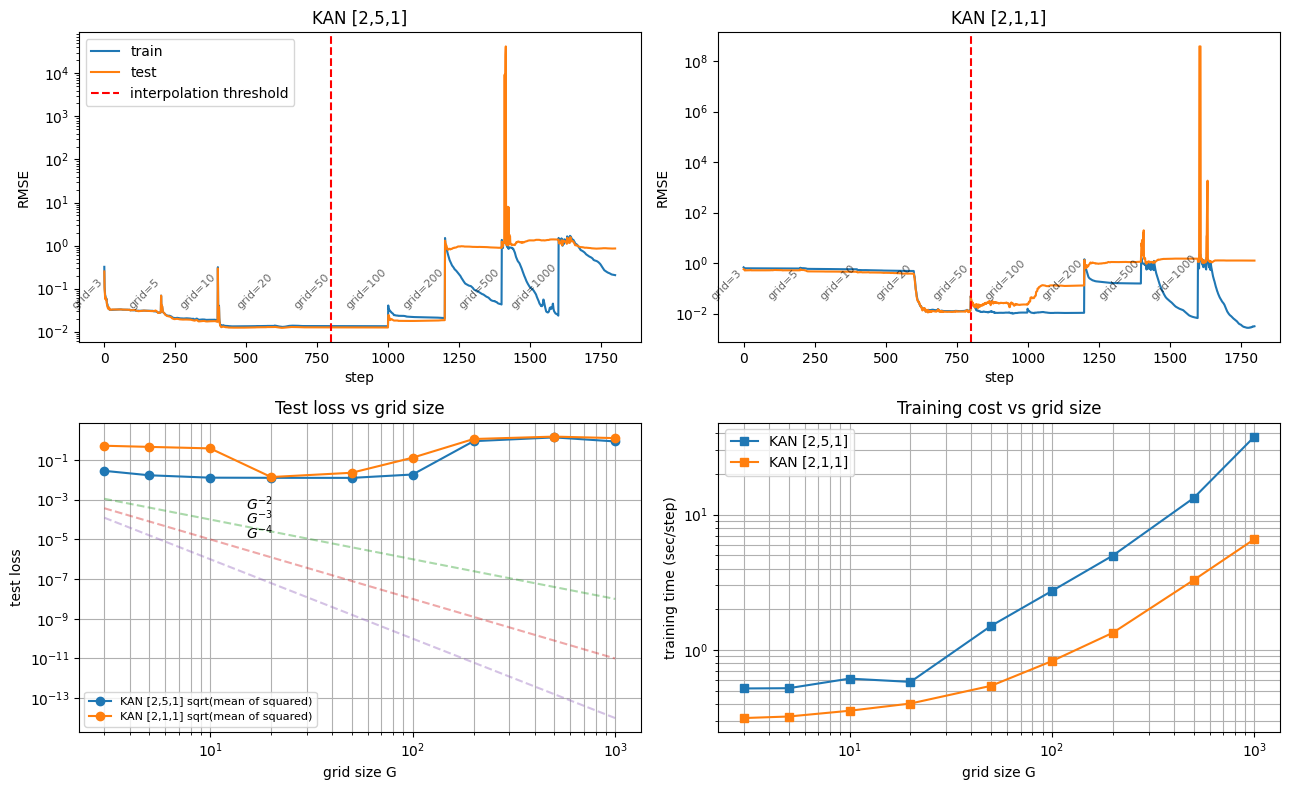

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(13, 8))

def annotate_grid(ax, x0, label):
    ax.text(x0, 3e-2, label, rotation=45,
            ha="right", va="bottom", fontsize=8, alpha=.6)

# top-row learning curves -----------------------------------------------------
for col, name in enumerate(ARCHES):
    ax   = axs[0, col]
    step = np.arange(len(results[name]["train_curve"]))
    ax.plot(step, results[name]["train_curve"], label="train")
    ax.plot(step, results[name]["test_curve"],  label="test", color="C1")
    ax.set_yscale("log");  ax.set_xlabel("step");  ax.set_ylabel("RMSE")
    ax.set_title(f"KAN {name}")
    # grid-change annotations
    cursor = 0
    for G in grid_sizes:
        annotate_grid(ax, cursor, f"grid={G}")
        cursor += steps_per_grid
    # interpolation threshold (15 G params ≈ #data → G≈67)
    ax.axvline(4 * steps_per_grid, color="r", ls="--",
               label="interpolation threshold")
    if col == 0:
        ax.legend()

# bottom-left : test RMSE vs grid size ---------------------------------------
ax = axs[1, 0]
for name in ARCHES:
    ax.plot(grid_sizes, results[name]["test_last"],
            marker='o', label=f"KAN {name} sqrt(mean of squared)")
ax.set_xscale("log"); ax.set_yscale("log")
ax.set_xlabel("grid size G"); ax.set_ylabel("test loss")
ax.set_title("Test loss vs grid size")

g = np.array(grid_sizes, dtype=float)
ax.plot(g, 1e-2 * g**-2,  ls="--", alpha=.4);  ax.text(15, 3e-4, r"$G^{-2}$")
ax.plot(g, 1e-2 * g**-3,  ls="--", alpha=.4);  ax.text(15, 6e-5, r"$G^{-3}$")
ax.plot(g, 1e-2 * g**-4,  ls="--", alpha=.4);  ax.text(15, 1e-5, r"$G^{-4}$")
ax.grid(True, which="both"); ax.legend(fontsize=8)

# bottom-right : seconds per step vs grid size --------------------------------
ax = axs[1, 1]
for name in ARCHES:
    ax.plot(grid_sizes, results[name]["time_step"],
            marker='s', label=f"KAN {name}")
ax.set_xscale("log"); ax.set_yscale("log")
ax.set_xlabel("grid size G"); ax.set_ylabel("training time (sec/step)")
ax.set_title("Training cost vs grid size")
ax.grid(True, which="both"); ax.legend()

plt.tight_layout();  plt.show()